In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy
from scipy import stats
import torch
import matplotlib.pyplot as plt

import torch
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

from torch.distributions import Gamma, Normal, Bernoulli, MultivariateNormal, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from tqdm.auto import trange

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Uniform
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [2]:
# Download MNIST dataset and create dataloaders. 
def binarize(imgs, integer=False):
    threshold = 127 if integer else 0.5
    imgs = imgs.clone()
    imgs[imgs < threshold] = 0.
    imgs[imgs >= threshold] = 1.
    return imgs

train_dataset = datasets.MNIST(root=".", train=True, download=True,
                         transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='.', train=False, download=True,
                             transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of points in dataset: {0}".format(train_dataset.data.shape[0]))
print("Number of batches per epoch: {0}".format(len(train_loader)))

Number of points in dataset: 60000
Number of batches per epoch: 938


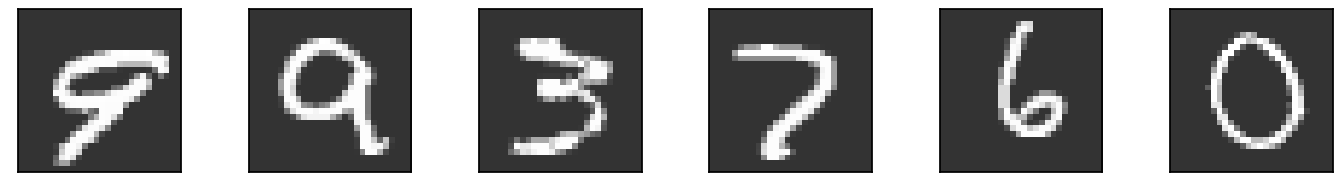

In [6]:
# Visualize some digits in the dataset.
imgs, _ = next(iter(train_loader))
#imgs = binarize(imgs)
fig, ax = plt.subplots(1, 6, figsize=(14, 14))
fig.tight_layout()
for i, ax in enumerate(ax.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(imgs[i].squeeze(), alpha=0.8, cmap='gray')

In [3]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[256, 512]):
        super().__init__()
        self.data_dim = data_dim

        ###
        # YOUR CODE HERE
        self.fc1 = nn.Linear(latent_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], data_dim)
        ## 
        
    def forward(self, z):
        """ Returns Bernoulli conditional distribution of p(x | z), parametrized
        by logits.
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Bernoulli distribution with a batch of (N, data_dim) logits
        """
        ###
        # YOUR CODE HERE
        h1 = F.relu(self.fc1(z))
        h2 = F.relu(self.fc2(h1))
        logits = self.fc3(h2)
        ## 
        return Bernoulli(logits=logits) # probs = sigmoid(logits)

In [4]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[512, 256]):
        super().__init__()

        ###
        # YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=data_dim, out_features=hidden_dims[0])
        self.fc2 = nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1])
        self.fc31 = nn.Linear(hidden_dims[1], latent_dim)
        self.fc32 = nn.Linear(hidden_dims[1], latent_dim)
        ##

    def forward(self, x):
        """ Returns Normal conditional distribution for q(z | x), with mean and
        log-variance output by a neural network.

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, latent_dim) means and standard deviations
        """
        ###
        # YOUR CODE HERE
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        means = self.fc31(h2)
        log_sigmasqs = self.fc32(h2)
        sigmas = torch.exp(0.5 * log_sigmasqs)
        return Normal(means, sigmas)

In [5]:
def elbo(x, encoder, decoder):
    """ Computes a stochastic estimate of the rescaled evidence lower bound

    Args:
        x: (N, data_dim) torch.tensor
        encoder: an Encoder
        decoder: a Decoder
    Returns:
        elbo: a (,) torch.tensor containing the estimate of the ELBO
    """
    ###
    # YOUR CODE HERE
    p_z = Normal(0, 1)
    q_z = encoder.forward(x)
    z = q_z.rsample() # sampling with reparametrization trick
    elbo = decoder.forward(z).log_prob(x).sum(dim=1).mean(dim=0)
    elbo -= kl_divergence(q_z, p_z).sum(dim=1).mean(dim=0)

    ##
    return elbo


In [6]:
encoder = Encoder(data_dim=784, latent_dim=2)
decoder = Decoder(data_dim=784, latent_dim=2)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=3e-4)

num_epochs = 20

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_elbo = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = binarize(x.reshape(x.shape[0], -1))
        optimizer.zero_grad()

        loss = -elbo(x, encoder, decoder)  
        loss.backward()
        train_elbo -= loss.item() * len(x)
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tELBO: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), -loss.item()))
            
    encoder.eval()
    decoder.eval()
    test_elbo = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = binarize(x.reshape(x.shape[0], -1))#.cuda()
            test_elbo += elbo(x, encoder, decoder).item() * len(x)
            
    train_elbo /= len(train_loader.dataset)
    test_elbo /= len(test_loader.dataset)
    
    print('====> Epoch: {} Average ELBO: {:.4f} Test ELBO: {:.4f}'.format(epoch,
                                                                          train_elbo,
                                                                          test_elbo))


Train Epoch: 0 [0/60000 (0%)]	ELBO: -543.347351
Train Epoch: 0 [6400/60000 (11%)]	ELBO: -217.836395
Train Epoch: 0 [12800/60000 (21%)]	ELBO: -198.828354
Train Epoch: 0 [19200/60000 (32%)]	ELBO: -168.879089
Train Epoch: 0 [25600/60000 (43%)]	ELBO: -173.028870
Train Epoch: 0 [32000/60000 (53%)]	ELBO: -167.776093
Train Epoch: 0 [38400/60000 (64%)]	ELBO: -164.328140
Train Epoch: 0 [44800/60000 (75%)]	ELBO: -176.574646
Train Epoch: 0 [51200/60000 (85%)]	ELBO: -155.431686
Train Epoch: 0 [57600/60000 (96%)]	ELBO: -148.957077
====> Epoch: 0 Average ELBO: -187.3956 Test ELBO: -165.8932
Train Epoch: 1 [0/60000 (0%)]	ELBO: -167.412842
Train Epoch: 1 [6400/60000 (11%)]	ELBO: -167.393219
Train Epoch: 1 [12800/60000 (21%)]	ELBO: -158.077484
Train Epoch: 1 [19200/60000 (32%)]	ELBO: -150.426422
Train Epoch: 1 [25600/60000 (43%)]	ELBO: -157.067352
Train Epoch: 1 [32000/60000 (53%)]	ELBO: -156.086594
Train Epoch: 1 [38400/60000 (64%)]	ELBO: -153.908661
Train Epoch: 1 [44800/60000 (75%)]	ELBO: -166.07011

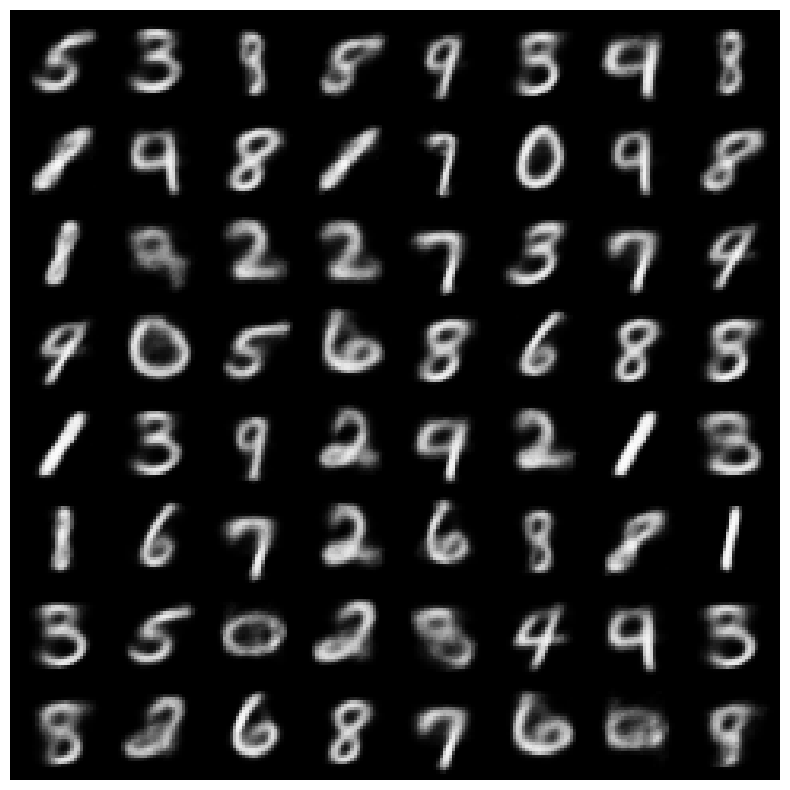

In [ ]:
# Visualize sampled digits from our model
decoder.eval()

num_samples = 64
with torch.no_grad():
    z = torch.randn(num_samples, 2)
    expected_xs = decoder.forward(z).mean 
    expected_xs = expected_xs.reshape(-1, 28, 28).unsqueeze(1)

# Plot the expected_xs as a grid of images
expected_xs_grid = make_grid(expected_xs, nrow=8)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(expected_xs_grid.permute(1, 2, 0), vmin=0., vmax=1.)
plt.show()

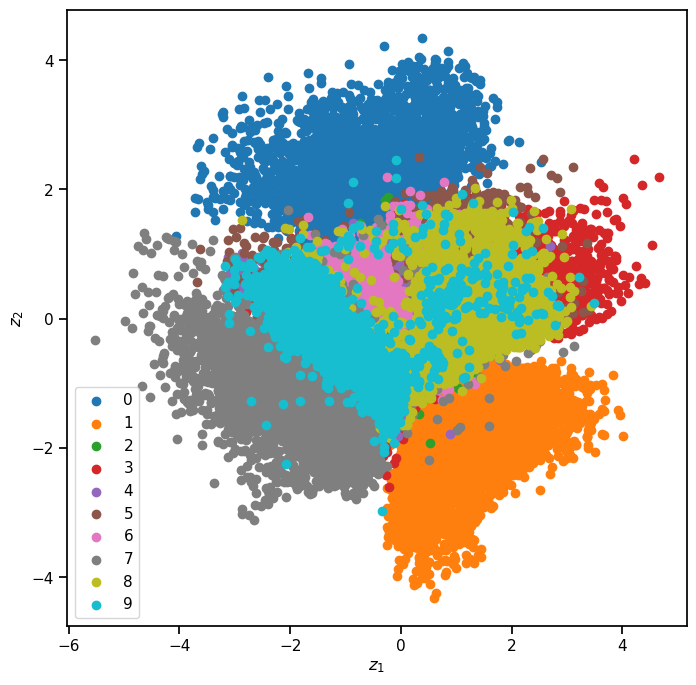

In [15]:
# Compute the mean of the latents given the data
encoder.eval()
with torch.no_grad():
    means = []
    ys = []
    for x, y in train_loader:        
        x = binarize(x.reshape(x.shape[0], -1))
        mean = encoder.forward(x).mean
        means.append(mean)
        ys.append(y)

means = torch.vstack(means)
ys = torch.hstack(ys)

# Plot the first two dimensions of the latents
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(10):
    means_i = means[ys == i]
    ax.scatter(means_i[:, 0], means_i[:, 1], label=str(i))

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.legend()

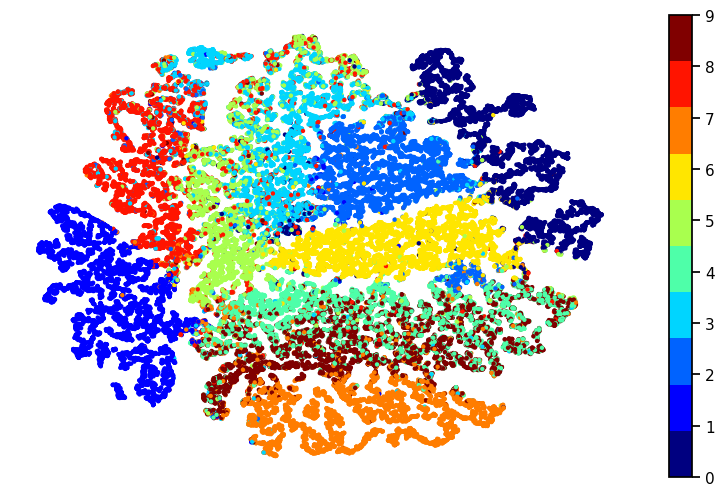

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(means)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ys, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('off')
plt.colorbar()

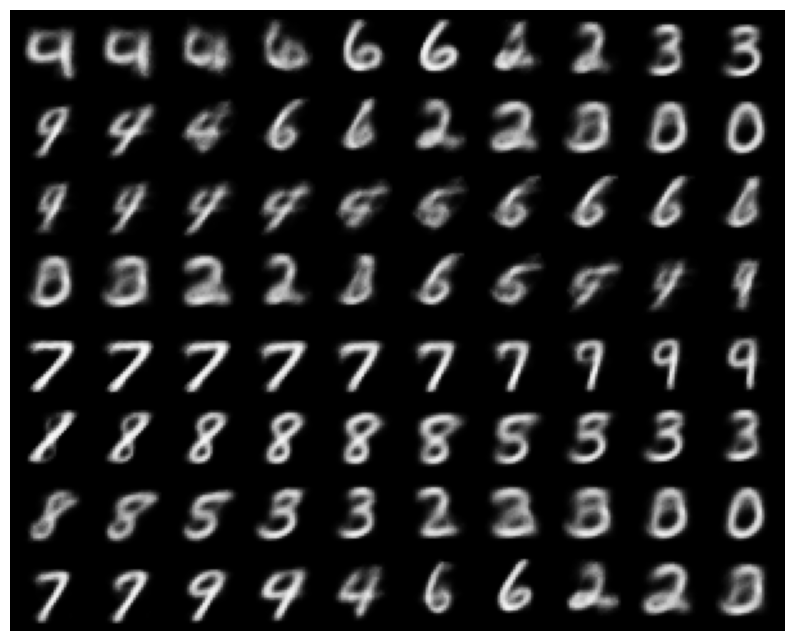

In [12]:
# Interpolate between 8 randomly chosen start and end points
latent_starts = torch.randn(8, 2)
latent_ends = torch.randn(8, 2)

means = []
for t in torch.linspace(0, 1, 10):
    z = latent_starts + t * (latent_ends - latent_starts)
    with torch.no_grad():
        means.append(decoder.forward(z).mean.reshape(-1, 28, 28).unsqueeze(0))

means_tensor = torch.vstack(means).permute(1, 0, 2, 3).reshape(-1, 28, 28).unsqueeze(1)
sample_grid = make_grid(means_tensor, nrow=10)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Text(0.5, 0.98, 'VAE')

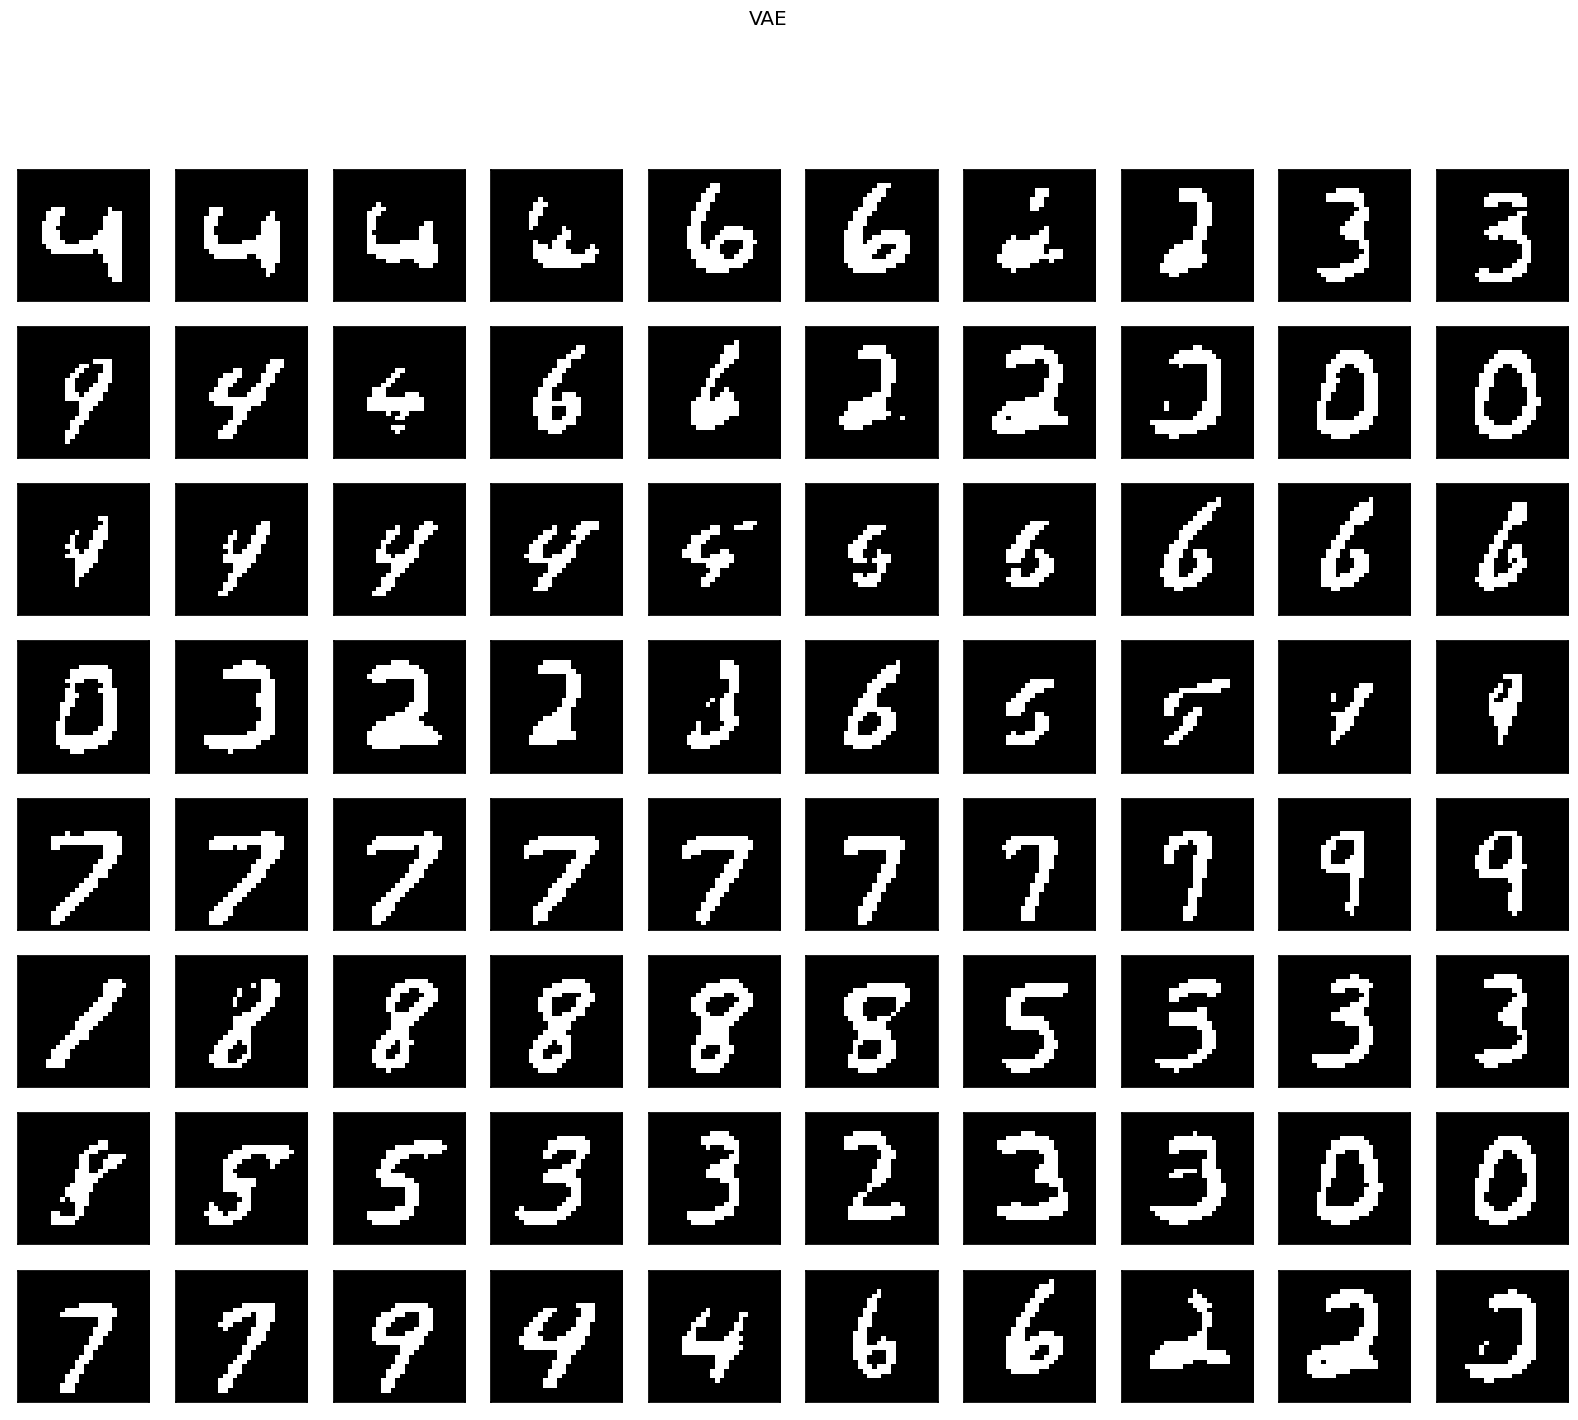

In [14]:
sample_grid = make_grid(means_tensor, nrow=10)
fig, axs = plt.subplots(8, 10, figsize=(20, 16))
for i in range(8):
    for j in range(10):
        axs[i, j].imshow(binarize(means_tensor.reshape(-1,28,28)[i * 10 + j]), interpolation="none", cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.suptitle("VAE")